## Importing Neccessary Libraries



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Input,concatenate
from tensorflow.keras.losses import CosineSimilarity
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
import random

In [ ]:
df = pd.read_csv('/content/sjvcsv.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Extracting Images and Converting them into Array

In [ ]:
width = 28
height = 28
X = []
for i in tqdm(range(df.shape[0])):
  path = '/content/drive/My Drive/tp1/'+df['ID'][i]+'.jpg'
  img = image.load_img(path,target_size=(width,height,3))
  img = image.img_to_array(img)
  img = img/255.0
  X.append(img)

X = np.array(X)

100%|██████████| 463/463 [03:38<00:00,  2.11it/s]


In [ ]:
X.shape

(463, 28, 28, 3)

In [ ]:
X[0].shape

(28, 28, 3)

## Batch of Triplets

In [ ]:
def create_batch(batch_size):
    anchors = np.zeros((batch_size,28,28,3))
    positives = np.zeros((batch_size,28,28,3))
    negatives = np.zeros((batch_size,28,28,3))
    
    for i in range(0,batch_size):
        index = random.randint(0,df.shape[0]-1)
        anc = X[index]
        name = df.Name[index]
        
        indices_for_pos = df.index[df['Name']==name].tolist()
        indices_for_pos = np.array(indices_for_pos)
        indices_for_pos = np.delete(indices_for_pos,np.where(indices_for_pos==index))

        indices_for_neg = df.index[df['Name']!=name].tolist()
        indices_for_neg = np.array(indices_for_neg)   
        
        pos = X[indices_for_pos[random.randint(0,len(indices_for_pos)-1)]]
        neg = X[indices_for_neg[random.randint(0,len(indices_for_neg)-1)]]
        
        anchors[i] = anc
        positives[i] = pos
        negatives[i] = neg
        
    return [anchors,positives,negatives]

## Embedding Model

In [ ]:
emb_dim=64
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu', input_shape=(28,28,3) ))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(emb_dim,activation=None))

In [ ]:
model.compile()

## Siamese Model

In [ ]:
in_anc = Input(shape=(28,28,3))
in_pos = Input(shape=(28,28,3))
in_neg = Input(shape=(28,28,3))

emb_anc = model(in_anc)
emb_pos = model(in_pos)
emb_neg = model(in_neg)

out = concatenate([emb_anc,emb_pos,emb_neg], axis=1)

net = Model(
    [in_anc,in_pos,in_neg],
    out
)

net.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64)           309280      input_1[0][0]                    
                                                                 input_2[0][0]         

## Triplet Loss

In [ ]:
cosine_loss = CosineSimilarity()

In [ ]:
def triplet_loss(alpha, emb_dim):#take alpha 0.06(cos(20))
    def loss(y_true, y_pred):
        anc, pos, neg = y_pred[:,:emb_dim], y_pred[:,emb_dim:2*emb_dim], y_pred[:, 2*emb_dim:]
        dp = 1 - abs(cosine_loss(anc,pos))
        dn = 1 - abs(cosine_loss(anc,neg))
        return tf.maximum((dp - dn + alpha),0.)
    return loss

## Model Generator

In [ ]:
def data_generator(batch_size, emb_dim):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size,3*emb_dim))
        yield x, y

## Model Training

In [ ]:
batch_size = 12
epochs = 10
steps_per_epoch = int(463/batch_size)

net.compile(loss = triplet_loss(alpha=0.06, emb_dim=emb_dim), optimizer=tf.keras.optimizers.Adam(lr=0.001))

In [ ]:
history = net.fit(
    data_generator(batch_size,emb_dim),
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    verbose=False,
)

In [ ]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,history.history['loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='upper right')
  plt.show()

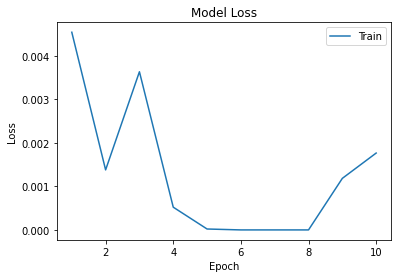

In [ ]:
plotLearningCurve(history,epochs)

## Testing

In [ ]:
df = pd.read_csv('/content/testing - Sheet1.csv')

In [ ]:
width = 28
height = 28
X = []
for i in tqdm(range(df.shape[0])):
  path = '/content/drive/My Drive/testingT/'+df['ID'][i]+'.jpg'
  img = image.load_img(path,target_size=(width,height,3))
  img = image.img_to_array(img)
  img = img/255.0
  X.append(img)

X = np.array(X)

100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


In [ ]:
[anchors,positives,negatives]=create_batch(10)

In [ ]:
def test(batch_size):
  for i in range(batch_size):
    a1 = model(tf.expand_dims(anchors[i],0))
    a2 = model(tf.expand_dims(positives[i],0))
    a3 = model(tf.expand_dims(negatives[i],0))
    print(abs(cosine_loss(a1,a2)))
    print(abs(cosine_loss(a1,a3)))
    print(abs(cosine_loss(a2,a3)))
    print("\n\n")


In [ ]:
test(10)

tf.Tensor(0.9903515, shape=(), dtype=float32)
tf.Tensor(0.62405777, shape=(), dtype=float32)
tf.Tensor(0.5626136, shape=(), dtype=float32)



tf.Tensor(0.8039705, shape=(), dtype=float32)
tf.Tensor(0.7024436, shape=(), dtype=float32)
tf.Tensor(0.88892555, shape=(), dtype=float32)



tf.Tensor(0.99999994, shape=(), dtype=float32)
tf.Tensor(0.5737278, shape=(), dtype=float32)
tf.Tensor(0.5737278, shape=(), dtype=float32)



tf.Tensor(0.9495739, shape=(), dtype=float32)
tf.Tensor(0.7740949, shape=(), dtype=float32)
tf.Tensor(0.6610004, shape=(), dtype=float32)



tf.Tensor(0.9903515, shape=(), dtype=float32)
tf.Tensor(0.44917455, shape=(), dtype=float32)
tf.Tensor(0.34899315, shape=(), dtype=float32)



tf.Tensor(0.97129154, shape=(), dtype=float32)
tf.Tensor(0.81750137, shape=(), dtype=float32)
tf.Tensor(0.8231797, shape=(), dtype=float32)



tf.Tensor(0.9826852, shape=(), dtype=float32)
tf.Tensor(0.32789442, shape=(), dtype=float32)
tf.Tensor(0.40448374, shape=(), dtype=float32)



tf.T